# 0. 인트로

Anomaly Detection 
본 실습 파일은 우선 다음의 대표적이고 기본적인 Anomaly Detection 방법론 3가지를 다룬다.  
-	Gaussian Density-based Anomaly Detection
-	Mixture of Gaussians Density Estimation
-	Auto Encoder


각각의 모델을 구현해보는 실습 이후에는 위 방법론들을 함께 사용하는 비교적 고도화된 모델 DAGMM(Zong, 2018) 모델을 다룬다.

-	DAGMM (Zong et al., ICLR 2018)

각각의 모델에 대한 이론적 내용을 가볍게 설명하고, 실제 python 코드로 실험을 수행하는 과정으로 진행되며, 기본적으로 동일한 데이터에 대한 각 모델의 결과를 비교하는 과정을 포함한다.

# 1. 이론 및 코드 구현
## 1.1	Anomaly Detection
Anomaly Detection은 이름에서 알 수 있듯이 Anomaly Data를 찾아내는 Task로 정상 데이터와 비정상 데이터를 구분해 내는 Task로 이해할 수 있다. 그렇다면 2 class Classification과 동일하게 느껴 질 수도 있는데, 두 Task는 다음과 같은 차이가 있다. 

 <p align="center">   <image src="./images/2022-11-16-23-39-00.png" width="60%"/>   </p>

Classification의 경우 각 클래스 별 데이터가 존재하고, 데이터의 label을 활용하여 해당 class를 예측하도록 학습이 된다. 그러나 Anomaly Detection의 경우에는 학습 상황에서는 정상의 데이터만 존재한다는 가정에서 정상 데이터의 특징을 파악할 수 있도록 학습되고, Test 상황에서 학습 과정에서 보지 못한 Anomaly data를 구분하는 과정이다.  

즉, two-class Classification의 경우 두가지 범주를 명시적으로 구분하는 것으로 한 class가 아니라면 반드시 다른 class인 상황이며, Anomaly Detection은 학습에 확인한 데이터와 동일한 성질의 데이터인지 아닌지 만을 판단하는 것이다. 즉, Anomaly라고 하더라도 엄밀히 말하면 불량 혹은 비정상 데이터인 것이 아니라 단지 학습에 보지 못한 새로운 성질의 데이터라고 하는 것이 옳다.  

Anomaly Detection의 방식은 크게 두 가지로 구분할 수 있는데, 첫째로는 학습 데이터를 통해 정상 데이터의 특징을 파악하고, 새로운 데이터에 대해서 원래 데이터와의 차이 등을 Anomaly score로 계산하여 특정 threshold를 넘으면 Anomaly로 판단하는 경우가 있다. 이번에 실습으로 알아볼 4가지 방법론들은 모두 이 첫번째 case에 해당한다. 두 번 째로는 방법론이 normal/Anomaly 데이터를 구분하는 명시적인 경계면을 생성해 주는 경우이다. 1-SVM이나 SVDD 방법론이 이 경우에 해당한다.  

 <p align="center">   <image src="./images/2022-11-16-23-39-27.png" width="60%"/>   </p>

In [254]:
# 이후의 모델 구현을 위한 라이브러리 및 데이터 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
# from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score , average_precision_score
from sklearn.metrics import precision_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

import tqdm
import time


In [255]:
# 데이터 불러오기: 본 데이터는 신용카드 거래 데이터로 다음과 같은 변수를 포함한다.
df = pd.read_csv("creditcard.csv")
print(df.columns.values)

['Time' 'V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7' 'V8' 'V9' 'V10' 'V11' 'V12'
 'V13' 'V14' 'V15' 'V16' 'V17' 'V18' 'V19' 'V20' 'V21' 'V22' 'V23' 'V24'
 'V25' 'V26' 'V27' 'V28' 'Amount' 'Class']


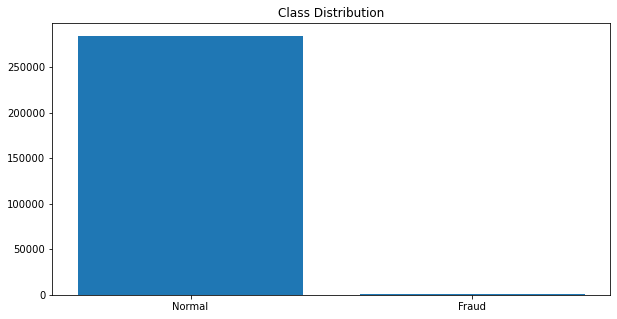

In [256]:
# 변수중 Class가 사기 거래인지 여부로 1이면 사기, 0이면 정상 거래를 의미한다.  
# 즉, 이번 Anomaly Detection에서는 Class가 1인 데이터를 이상치로 판단한다.
x = df['Class'].value_counts().index
y = df['Class'].value_counts().values

plt.figure(figsize=(10, 5))
plt.bar(x, y)
plt.xticks(x, ['Normal', 'Fraud'])
plt.title('Class Distribution')
plt.show()

# 편의를 위해 변수중 중요하다고 알려진 ['V3' 'V4' 'V7' 'V9' 'V10' 'V11' 'V12' 'V14' 'V16' 'V17' 'V18' 'Class']만 사용
df = df[['V3', 'V4', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16' ,'V17', 'V18', 'Class']]

위 그래프를 보면 데이터에서 정상 거래와 사기거래의 비율이 매우 불균형한 것을 알 수 있다.
즉, Classification이 아닌 Anomaly Detection으로 모델을 구현해야 한다.

In [257]:
# Class가 0인 데이터만을 포함하는 학습데이터와 정상, 비정상 데이터가 섞인 테스트 데이터를 생성한다.
df_normal=df[df['Class'] == 0]
df_frud=df[df['Class'] == 1]
df_normal = df_normal.sample(frac=1).reset_index(drop=True)
train_data_size = int(len(df_normal)*0.8)
train_df=df_normal[:train_data_size].drop(['Class'], axis=1)
train_target=df_normal[:train_data_size]['Class']

test_df=df_normal[train_data_size:]
test_df=pd.concat([test_df, df_frud], axis=0,ignore_index=True).sample(frac=1).reset_index(drop=True)
test_target=test_df['Class']
test_df=test_df.drop(['Class'], axis=1)


In [258]:
# 이후의 데이터 분석의 과정에서 데이터의 변수들이 모두 동일한 스케일을 갖도록 StandardScaler를 사용하여 스케일링한다.
scaler = StandardScaler()
scaler.fit(train_df)
train_df = scaler.transform(train_df)
test_df = scaler.transform(test_df)

In [172]:
train_df

array([[-1.09795249,  0.61259146,  6.58291625, ..., -2.30632139,
         0.50935967,  2.40694181],
       [ 0.86395855,  1.1164731 , -0.36455043, ...,  0.23101347,
        -0.41152237,  0.13438191],
       [-0.74565953, -0.92216026, -0.90387998, ..., -1.54051545,
         1.41662554, -0.82279752],
       ...,
       [-0.22965871, -0.04522134,  0.3132716 , ...,  0.42754082,
        -0.69142909, -0.89182143],
       [ 0.50148564, -1.05070678, -1.44818478, ...,  0.08899021,
         0.10186872,  1.20646265],
       [ 0.87352953,  1.2130098 , -0.49362136, ..., -1.1997954 ,
         0.78186833, -1.12355746]])

In [173]:
test_df

array([[ 0.338509  ,  0.3909924 ,  0.45925715, ..., -0.04375216,
         1.22324226,  0.07553191],
       [-0.46162984, -0.32517525,  0.5831222 , ..., -0.52958264,
        -0.39401647,  0.03589929],
       [-1.61533929,  0.27687489,  0.24808873, ..., -0.55885102,
         1.89674982, -0.6839821 ],
       ...,
       [-0.28753687, -0.37432762,  0.74953894, ...,  0.35428057,
         0.63619227, -0.2533023 ],
       [-0.75266307, -0.39233698, -0.45784117, ...,  0.75043416,
        -1.2272715 , -0.09033819],
       [-0.79191155, -1.78481424, -1.26177947, ..., -0.10020235,
        -0.00678816,  0.47440001]])

## 1.2	Gaussian Density-based Anomaly Detection

 <p align="center">   <image src="./images/2022-11-16-23-39-51.png" width="60%"/>   </p>

가장 첫 째로 살펴볼 방법론인 Gaussian Density-based Anomaly Detection은 정상의 학습데이터가 기저에서 Gaussian distribution을 따른다는 가정에서 데이터가 생성되는 데 사용된 분포를 추정하고, 새로운 데이터가 해당 분포에서 생성될만 한지를 통해 Anomaly Detection을 수행한다. 한마디로 하자면 다음과 같다. "학습 데이터를 보니 이 데이터들은 평균 0이고 분산이 10인 Gaussian 분포를 따르는 거 같은데, 새로운 데이터의 값이 10000이니 이건 같은 분포에서 생성된 데이터는 아니겠다. 이건 이상치네!"  

실제 과정은 다음과 같이 1)Gaussian parameter 추정, 2) test 데이터의 Anomaly Score 산출로 이루어진다.  
 
1) Gaussian parameter 추정  
  : 학습데이터에 대해 Maximum Likelihood Estimation을 수행해 단순 계산으로 구한다.  

 <p align="center">   <image src="./images/2022-11-16-23-40-08.png" width="60%"/>   </p>

2) test 데이터의 Anomaly Score 산출  
  : 위에서 찾은 Gaussian parameter를 가지는 Gaussian Distribution에 대해 각 데이터의 확률을 계산하고, 그 확률이 특정 threshold 보다 작다면 이상치로 판단한다.

 <p align="center">   <image src="./images/2022-11-16-23-40-18.png" width="60%"/>   </p>


장점  
  
수식에서 보았듯이 쉽게 빠르게 연산이 가능한 방법론이며, 분포상의 확률이라는 직관적인 Anomaly Score를 제공한다. 또한 threshold를 조절하는 것을 통해 상황에 맞게 대응이 가능하다.

In [185]:
# Gaussian Density-based Anomaly Detection 코드 구현

#  1. Gaussian parameters 구하기
def estimateGaussian(X):
    mu = np.mean(X, axis=0)
    sigma = np.cov(X.T)
    return mu, sigma
    
#  2. Gaussian parameters를 이용하여 Anomaly Score 구하기
def multivariateGaussian(X, mu, sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(X)

#  3. Anomaly Score를 이용하여 Threshold 구하기
def selectThreshold(target, p):
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
    stepsize = (max(p) - min(p)) / 1000
    for epsilon in np.arange(min(p), max(p), stepsize):
        predictions = (p < epsilon)
        # class 간 불균형있고, 범주 중 사기거래 범주에 더욱 중요한 상황이므로 F1 score를 사용한다.
        F1 = f1_score(np.array(target), predictions)
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
    return bestF1, bestEpsilon

In [178]:
# 정의한 함수를 통해 데이터의 변수에 따른 Gaussian parameters를 구한다.
mu, sigma = estimateGaussian(train_df)

print(f'mu: {mu}')
print(f'sigma: {sigma}')

mu: [-1.32454373e-17  2.51788265e-17 -3.37383780e-18  2.25547305e-17
  1.24956955e-17  8.24715906e-18  3.87366562e-18 -6.90387179e-18
 -2.16800318e-17 -4.77960355e-18 -1.78063662e-17]
sigma: [[ 1.0000044   0.0384964  -0.08239973 -0.03465707 -0.0783181   0.04426141
  -0.08098006 -0.08151095 -0.06567352 -0.12049583 -0.03820431]
 [ 0.0384964   1.0000044   0.04003199  0.01807907  0.04166163 -0.02847871
   0.04820642  0.05369074  0.03887926  0.06845537  0.02263542]
 [-0.08239973  0.04003199  1.0000044  -0.03443295 -0.08261571  0.04708865
  -0.0902637  -0.08304946 -0.06709992 -0.14139273 -0.05025419]
 [-0.03465707  0.01807907 -0.03443295  1.0000044  -0.03552605  0.02410527
  -0.04123797 -0.04103343 -0.03264606 -0.06306157 -0.02085331]
 [-0.0783181   0.04166163 -0.08261571 -0.03552605  1.0000044   0.05127886
  -0.09412433 -0.09524189 -0.07651056 -0.14325681 -0.04688237]
 [ 0.04426141 -0.02847871  0.04708865  0.02410527  0.05127886  1.0000044
   0.06264554  0.06702706  0.04740946  0.08522583  

In [190]:
# 다음으로 구한 Gaussian parameters를 이용하여 각 데이터가 다변량 가우시안 분포에 대해서 발생할 확률을 구한다.
p_test = multivariateGaussian(test_df,mu,sigma)
print(f'각 데이터의 발생확률 p: {p}, 데이터의 개수: {len(p)}')

각 데이터의 발생확률 p: [1.40797931e-06 1.54442529e-05 1.33019841e-07 ... 9.77796229e-06
 9.61537448e-06 1.13357318e-07], 데이터의 개수: 57355


(array([3.9008e+04, 8.3590e+03, 5.0430e+03, 2.2740e+03, 1.2270e+03,
        6.9800e+02, 4.0700e+02, 2.2900e+02, 1.0500e+02, 5.0000e+00]),
 array([0.00000000e+00, 4.15285173e-06, 8.30570347e-06, 1.24585552e-05,
        1.66114069e-05, 2.07642587e-05, 2.49171104e-05, 2.90699621e-05,
        3.32228139e-05, 3.73756656e-05, 4.15285173e-05]),
 <BarContainer object of 10 artists>)

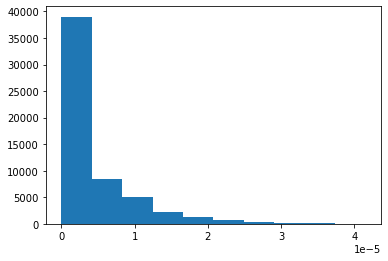

In [191]:
plt.hist(p_test)

In [192]:
# 다음으로는 현재 계산된 p값 즉, Anomaly Score를 어느 기준에서 비정상 데이터로 판단할지 threshold를 구한다.
fscore, ep= selectThreshold(test_target,p_test)
print(f'fscore: {fscore}, ep: {ep}')

# 본 데이터와 같이 복잡한 데이터의 경우, 기본적인 Gaussian Density-based Anomaly Detection에는 좋은 성능을 보이지 못하고 있다.

fscore: 0.08507042253521127, ep: 4.1528517343356454e-08


## 1.3	Mixture of Gaussians Density Estimation
앞서 설명한 Gaussian Density-based Anomaly Detection 방법론의 경우 쉽게 적용 가능하다는 것이 장점이지만, 다소 세상을 너무 쉽게 본 경향이 있다. 과연 실제 현실의 데이터가 하나의 정규분포로부터 발생하였을까? 세상의 다양한 현상들이 크게 보면 정규 분포를 따르는 경향이 있는 것은 분명하지만, 확실하게 다수의 분포로부터 데이터가 발생했다고 보는 것이 더 정확한 경우는 많이 있다. 간단한 예시를 들어보면 사람의 신장에 대한 분포를 살펴본다면 나름대로 Gaussian 분포를 따를 수도 있지만, 성별에 따라 조금 다른 분포를 보일 수 있다는 건 쉽게 생각할 수 있다. 또 만약 국가가 달라진다면 국민들의 키가 키기로 유명한 북유럽 국가 국민들의 키 분포와 우리나라의 키 분포가 과연 하나의 단봉(분포의 모양이 봉우리가 하나라는 의미) Gaussian 분포를 이룰까? 이런 상황을 분석하기 위해서 우리는 여러 개의 Gaussian 분포를 선형 결합한 Mixture of Gaussians를 사용하곤 한다. 이 아이디어를 Anomaly Detection에 적용한 것이 이번에 알아볼 Mixture of Gaussians Density Estimation 방법론이다.  

 <p align="center">   <image src="./images/2022-11-16-23-40-36.png" width="60%"/>   </p>

데이터에 대해 추정하는 분포가 단봉이 아니라 multi-mode(다봉)라는 것만 제외한다면 Anomaly Detection의 아이디어는 동일하다. 데이터를 통해 추정한 분포에 대해서 새로운 test 데이터가 발생할 확률이 작다면 이상치로 판단하는 것이다.  

가장 큰 차이가 발생하는 부분은 분포의 파라미터(모수, parameter)를 추정하는 과정이 단봉이었을 때와는 다르게 한 번에 최적화가 불가능하고 EM알고리즘을 통해 순차적으로 찾아가야 한다는 것이다. 기존의 단봉 상황에선 모든 데이터가 하나의 가우시안 분포로부터 기인했다는 가정을 하기 때문에 모든 데이터를 사용하여 Maximum Likely Estimation을 통해 단순 계산으로 파라미터를 구할 수 있었다. 그러나 현재 multi-mode 상황에서는 어떤 데이터가 어떤 mode로부터 생성되었는지를 알지 못해, 어떤 데이터를 통해 어떤 mode의 파라미터를 계산해야 하는지 알 수가 없다. 또한 각각의 mode가 결합되는 비율도 알 수가 없다. EM 알고리즘은 Expectation–maximization algorithm의 줄임 말로 지금처럼 한 번에 최적화가 불가능한 상황에서 Expectation, maximization 과정을 반복하는 것으로 최적화를 수행하는 대표적인 방법이다.  

각각의 과정은 다음과 같은 역할을 수행한다.  
- Expectation: 현재 시점의 파라미터를 사용해 어떤 데이터가 어떤 가우시안 분포에 할당되어야 최대 likelihood를 가지는 지를 통해 데이터를 mode에 할당  

 <p align="center">   <image src="./images/2022-11-16-23-41-09.png" width="60%"/>   </p>

- Maximization: 현재 할당된 데이터를 기분으로 likelihood를 최대화하도록 각 가우시안 분포의 파라미터 업데이트  

 <p align="center">   <image src="./images/2022-11-16-23-41-30.png" width="60%"/>   </p>
 
즉, 최적화의 과정을 정리하면 다음과 같다.  

1)	가우시안 파라미터 랜덤 초기화  
2)	Expectation  
3)	Maximization  
4)	E-M 과정 정해진 수만큼 반복  
추가로 전체적인 수식은 다음과 같다.  

 <p align="center">   <image src="./images/2022-11-16-23-41-49.png" width="60%"/>   </p>

추가로 연산 효율을 위해 다양한 형태의 공분산 행렬 사용 가능하며 공분산 행렬 형태에 따라 다양한 Mixture of Gaussians 형태가 발생한다.  

 <p align="center">   <image src="./images/2022-11-16-23-42-03.png" width="60%"/>   </p>

In [262]:
# Mixture of Gaussians Density Estimation 코드 구현
# 본 방법론의 경우도 Gaussian Density-based Anomaly Detection과 마찬가지로 Gaussian parameters를 구하는 과정이 필요하다.
# 다만, 본 방법론은 Gaussian parameters를 구하는 과정에서 EM 알고리즘을 사용한다.

# 1. M-step Gaussian parameters 구하기
# 먼저 파라미터 초기화를 위한 함수를 정의한다.

class theta():
    def __init__(self, pi, mu, Sigma):
        self.pi = pi
        self.mu = mu
        self.Sigma = Sigma

# 다음으로 각각의 파라미터를 계산하기위한 함수를 정의한다.
def get_gamma(theta_val, X, K):
    gamma = np.empty((0,K))

    for n in range(len(X)):
        gamma_n = np.array([])

        for k in range(K):
            denom_elem = np.array([])
            for j in range(K):
                dist_j = multivariate_normal(
                    mean=theta_val.mu[j],
                    cov=theta_val.Sigma[j])
                denom_elem = np.append(denom_elem, theta_val.pi[j] * dist_j.pdf(X[n]))
            denom = denom_elem.sum()

            dist_k = multivariate_normal(
                mean=theta_val.mu[k],
                cov=theta_val.Sigma[k])
            numer = theta_val.pi[k] * dist_k.pdf(X[n])

            gamma_n = np.append(gamma_n, numer / denom)

        gamma = np.vstack((gamma, gamma_n))

    return gamma

def get_mu(gamma, X, K):
    mu_new = np.zeros((K,X.shape[1]), dtype=np.float64)

    for k in range(K):
        denom = sum(gamma[n][k] for n in range(len(X)))
        numer_x = sum(gamma[n][k] * X[n][0] for n in range(len(X)))
        mu_new[k][0] = numer_x / denom
        numer_y = sum(gamma[n][k] * X[n][1] for n in range(len(X)))
        mu_new[k][1] = numer_y / denom

    return mu_new

def get_sigma(gamma, mu_new, X, K):
    Sigma_new = np.empty((0,X.shape[1],X.shape[1]))

    for k in range(K):
        denom = sum(gamma[n][k] for n in range(len(X)))
        numer = np.zeros((X.shape[1],X.shape[1]), dtype=np.float64)
        for n in range(len(X)):
            sub = np.subtract(X[n], mu_new[k])
            sub = np.array([sub])
            sub_t = sub.transpose()
            numer = numer + gamma[n][k] * np.matmul(sub_t, sub)
        Sigma_new = np.vstack((Sigma_new, [numer / denom]))

    return Sigma_new

def get_pi(gamma, X, K):
    pi_new = np.array([])

    for k in range(K):
        pi_new = np.append(
            pi_new,
            sum(gamma[n][k] for n in range(len(X))) / len(X))

    return pi_new

In [263]:
cov=np.ones(K*train_df.shape[1]*train_df.shape[1]).reshape(K,train_df.shape[1],train_df.shape[1])
for i in range(K):
    cov[i]=np.stack(np.cov(train_df, rowvar=False), axis=0)

# 가우시안의 갯수 K는 하이퍼 파라미터이므로 미리 정의해 준다. 
K = 3

#파라미터 초기화
theta_old = theta(
    pi=np.random.dirichlet(np.ones(K),size=1)[0],
    mu=np.random.random(K*train_df.shape[1]).reshape(K,train_df.shape[1]),
    Sigma=cov,
    X=train_df,
    K=K
    )

TypeError: __init__() got an unexpected keyword argument 'X'

In [264]:
# 빠른 학습을 위해 데이터를 샘플링한다.
train_df_sample = train_df[0:1000]

# EM 알고리즘 수행
for loop in range(5):
    print(f"Running iteration {loop + 1} ...", end="\r")
    # Get gamma
    l_gamma = get_gamma(theta_old, train_df_sample,K)
    # Get new mu
    l_mu_new = get_mu(l_gamma,train_df_sample,K)
    # Get new sigma
    l_sigma_new = get_sigma(l_gamma, l_mu_new,train_df_sample,K)
    # Get new pi
    l_pi_new = get_pi(l_gamma,train_df_sample,K)
    # Replace theta
    theta_old = theta(
        pi=l_pi_new,
        mu=l_mu_new,
        Sigma=l_sigma_new
    )
print(f"pi:{theta_old.pi}, mu:{theta_old.mu}, Sigma:{theta_old.Sigma}")

pi:[0.54923453 0.32823426 0.1225312 ], mu:[[ 0.1203064   0.33999383  0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [ 0.18869778 -0.45188965  0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]
 [-1.08800239 -0.25301551  0.          0.          0.          0.
   0.          0.          0.          0.          0.        ]], Sigma:[[[ 0.63361202  0.0116806  -0.03744429 -0.07651651 -0.05846848
    0.03507806 -0.09539221  0.02949058 -0.0099766  -0.03844385
   -0.03500031]
  [ 0.0116806   0.80824855 -0.08610826 -0.27617699  0.42966475
   -0.06654013 -0.07440725  0.01959957  0.09112187  0.03252597
    0.01509151]
  [-0.03744429 -0.08610826  0.2949155  -0.17897744 -0.0933303
   -0.07408895  0.00558935 -0.02969472 -0.06390211 -0.0143603
   -0.03955604]
  [-0.07651651 -0.27617699 -0.17897744  0.78184135 -0.30973886
    0.05932896 -0.26631692  0.20460743 -0.05444915  0.09735953
    0.0245703

In [265]:
# 학습된 파라미터를 받아서 테스트 데이터에 대한 예측값을 구하는 함수를 정의한다.

pi=theta_old.pi
mu=theta_old.mu
Sigma=theta_old.Sigma

pi.shape, mu.shape, Sigma.shape


((3,), (3, 11), (3, 11, 11))

In [269]:
sigma[0]

array([ 1.0000044 ,  0.0384964 , -0.08239973, -0.03465707, -0.0783181 ,
        0.04426141, -0.08098006, -0.08151095, -0.06567352, -0.12049583,
       -0.03820431])

In [ ]:
p = pi[0]*multivariate_normal(mean=mu[0], cov=sigma[0])+pi[1]*multivariate_normal(mean=mu[1], cov=sigma[1])+pi[2]*multivariate_normal(mean=mu[2], cov=sigma[2])
prob=p.pdf(test_df)


In [ ]:
prob=p.pdf(test_df)

## 1.4	Auto Encoder
우선 Auto-Encoder 자체에 대해 이야기 해보자. Auto-Encode란 입력과 출력이 동일한 Encoder & Decoder 구조의 인공신경망이다.

 <p align="center">   <image src="./images/2022-11-16-23-58-39.png" width="60%"/>   </p>

위 그림에서도 확인이 가능한데, 모델의 input과 output이 모두 X로 동일하다. 또한 아래의 그림을 보면 입력과 출력의 크기가 동일한 것에 비해 중간의 latent Vector는 더 적은 차원을 가진 것을 확인 할 수 있다.

 <p align="center">   <image src="./images/2022-11-17-00-01-14.png" width="60%"/>   </p>

이는 입력 변수보다 적은 차원의 Latent Space를 거치는 것으로 정보의 축약을 수행하는 것으로, 모델은 이처럼 입력을 축약하는 Mapping 과정과 그를 다시 복원하는 de-mapping 과정을 거친다. 모델의 학습은 입력과 출력이 최대한 동일해지도록 수행되며, 이 과정을 통해 모델은 입력 데이터를 보다 확실히 이해할 수 있게된다.

 <p align="center">   <image src="./images/2022-11-17-00-05-29.png" width="60%"/>   </p>

이런 Auto-Encoder의 활용은 크게 두가지가 있는데, 첫 째로는 데이터 차원 축소 도구로써 역할을 수행하여 latent vector가 다른 ML 모델의 input으로 사용되도록 하는 경우이다. 두 번째는 이번 실습의 주제인 Anomaly Detection을 수행하는 것인데, 기본적인 Anomaly detection 학습의 과정과 동일하게 모델은 정상 데이터만을 통해 학습이 되므로 모델은 정상 데이터를 압축, 복원하는 방법을 익히게 된다. 즉, 새로이 비정상 데이터가 들어온다면 모델을 통과한 결과 제대로 복원되지 못할 것이고, Reconstruction Loss가 큰게 나타나게 된다.

 <p align="center">   <image src="./images/2022-11-17-02-12-04.png" width="60%"/>   </p>

Auto-Encoder의 장점은 복원되는 정도가 어느 위치에서 영향을 받는지 확인이 가능하다는 점이 있는데, 이는 위 그림에서 잘 나타난다.

In [2]:
# Auto Encoder 코드 구현

# 1.5 DAGMM
마지막으로 기본적인 방법론들에서 조금 더 나아가 살펴볼 모델은 앞서 설명한 Mixture of Gaussians Density Estimation과 Auto-Encoder를 함께 사용하는 DEEP AUTOENCODING GAUSSIAN MIXTURE MODEL 이다. 본 방법론은 DEEP AUTOENCODING GAUSSIAN MIXTURE MODEL FOR UNSUPERVISED ANOMALY DETECTION (Zong et al., ICLR 2018) 논문에서 제안된 방식으로 전체적인 구조는 아래와 같다.

 <p align="center">   <image src="./images/2022-11-17-02-20-58.png" width="60%"/>   </p>

그림에서 알 수 있듯이 Auto-Encoder로 구성된 Compression Network와 Mixture of Gaussians Density Estimation의 Estimation역할을 수행하는 Estimation Network로 구성되는 모델로, Auto-Encoder의 또 다른 활용법인 차원축소를 통해 얻은 저차원의 결과를 Mixture of Gaussians Density Estimation에 활용한다고 보면 된다.  

하나 짚고 넘어갈 점은 일전 Mixture of Gaussians Density Estimation를 설명할 때, EM 알고리즘은 Expectation & Maximization의 약자라고 설명하였으나 본 논문에서는 Estimation으로 용어를 사용하고 있다. 실제로 의미가 비슷하기도 하고 다양한 출처에서 둘을 혼용하고 있으니 참고바란다.  

DAGMM의 지적하는 기존 방법론의 문제점은 바로 이 EM 알고리즘을 통해 최적화되야 한다는 점으로, 본 방법론은 end-to-end 학습이 가능한 구조이다. Auto-Encoder가 사용되는 부분은 차원의 축소를 담당하는 것으로 이상치 탐지에는 비교적 직접적으로 사용되지는 않으며 핵심은 Estimation Network에 있다. 이 Estimation Network는 MLN이 반복되고 마지막에 Softmax layer가 있는 구조로 Compression Network의 결과를 받아 최종적으로 각각의 데이터 포인트가 어떤 가우시안 mode에 포함될지를 확률의 형태로 산출해 준다. 기존의 GMM에 EM 알고리즘이 필요했던 이유는 각 데이터가 어떤 mode에 속하는지 결정이 되어야 가우시안의 파라미터를 계산할 수가 있고, 동시에 각 가우시안의 파라미터가 결정이 되어있어야 데이터들의 likelyhood를 계산 할 수 있기 때문에 동시에 최적화가 불가능 하다는 것이었다. 그러나 DAGMM 처럼 모델의 output에 직접적으로 각 데이터 포인트가 어떤 mode에 속하는지를 확률로 알려준다면 그를 활용해 바로 가우시안 분포의 파라미터 추정할 수가 있고 최종적으로 Objective function 최적화를 수행할 수가 있다.

전체적인 Process와 계산식은 다음과 같다.

 <p align="center">   <image src="./images/2022-11-17-02-34-10.png" width="60%"/>   </p>

특징적인 부분만을 일부 더 살펴보면 Compression Network에서는 일반적인 차원 축소의 결과로 latent vector만을 사용하는 것과는 다르게, Auto-Encoder 입력과 출력 사이의 cos similarity와 L2 norm을 계산한 것을 concatenation하여 사용한다는 것이다.  

또 Loss를 보면 크게 세 가지 부분으로 구분이 되는데, 순서대로 Auto-Encoder 학습을 담당하는 Reconstruction error, Likelihood와 유사하게 작동하여 input을 관측할 확률이 높아지도록 하는 Sample energy Function이 있으며, 마지막으로는 GMM과 동일하게 특정한 position에서 data의 발생확률이 지나치게 높게 학습되는 특이점 문제를 방지하기 위해 공분산 행렬의 대각의 값들이 0이 되는 것을 방지하는 Penalized Diagonal Entries term이 있다.

In [3]:
# DAGMM 코드 구현

# 2. 코드 실습
## 2.1 데이터 load
## 2.2 Gaussian Density-based Anomaly Detection
## 2.3 Mixture of Gaussians Density Estimation
## 2.4 Auto Encoder
## 2.5 DAGMM

# 3. 동일한 데이터에 대한 모델 비교 실험 및 결과 분석석
## 3.1 각 모델의 하이퍼 파라미터 개수 비교
## 3.2 End-to-end 여부
## 3.3 단순 성능
## 3.4 실행 시간
## 3.5 Anomaly Detection threshold에 따른 민감성, robustness, AUROC

Reference
DEEP AUTOENCODING GAUSSIAN MIXTURE MODEL FOR UNSUPERVISED ANOMALY DETECTION (Zong et al., ICLR 2018)

https://www.kaggle.com/code/shelars1985/anomaly-detection-using-gaussian-distribution/notebook

https://github.com/tsmatz/gmm/blob/master/01-gmm-em-algorithm.ipynb
